# Import Libraries

In [1]:
pip install imbalanced-learn

In [7]:
import kagglehub
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

Dataset Source:
[Synthetic Finacial Datasets For Fraud Detection (Kaggle)](https://www.kaggle.com/datasets/ealaxi/paysim1)

In [9]:
path = kagglehub.dataset_download("ealaxi/paysim1")
files = os.listdir(path)
print(files)

100%|██████████| 178M/178M [00:06<00:00, 28.0MB/s]

Extracting files...


['PS_20174392719_1491204439457_log.csv']


In [10]:
df = pd.read_csv(os.path.join(path, 'PS_20174392719_1491204439457_log.csv'), nrows=50000)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
# dimensi dataset

df.shape

(50000, 11)

In [12]:
# informasi dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [13]:
# memeriksa missing value

print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [14]:
# memeriksan duplikasi data

duplicated = df.duplicated().sum()
duplicated

np.int64(0)



*   Dataset ini memiliki 20000 baris, dengan 11 kolom
*   Tidak diperlukan *data cleaning* karena tidak ada *missing value* atau duplikasi data



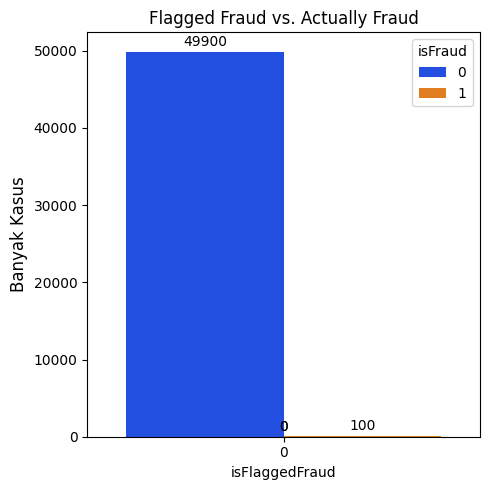

In [15]:
flagged_data = df.loc[df['isFlaggedFraud']==1]

# membuat countplot

plt.figure(figsize=(5, 5))
flag_plot = sns.countplot(x='isFlaggedFraud', data=df, hue='isFraud', palette='bright')


plt.title('Flagged Fraud vs. Actually Fraud', fontsize=12)
plt.ylabel('Banyak Kasus', fontsize=12)


for p in flag_plot.patches:
    height = p.get_height()
    if not np.isnan(height):  # Check if the height is not NaN and greater than 0
        flag_plot.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black',
                    xytext=(0, 7),  # adjust the vertical offset
                    textcoords='offset points')

# Display the plot
plt.tight_layout()
plt.show()

Dari semua transaksi pada 50000 baris teratas, tidak ada yang ditandai sebagai *fraud*. Artinya sistem belum bisa membaca dengan baik. Namun, jika sistem menandai transaksi sebagai *fraud*, maka transaksi tersebut sudah pasti adalah *fraud*.

In [16]:
# Maka dari itu, karena sistem isFlaggedFraud tidak memberikan korelasi apapun,
# Fitur ini akan dibuang

df = df.drop(['isFlaggedFraud'], axis = 1)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [17]:
class_counts = df['isFraud'].value_counts()
print(class_counts)

isFraud
0    49900
1      100
Name: count, dtype: int64


# Data Preprocessing

In [18]:
# menghapus fitur yang tidak digunakan

df.drop(['step', 'nameOrig', 'nameDest'], axis=1, inplace=True)

df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            50000 non-null  object 
 1   amount          50000 non-null  float64
 2   oldbalanceOrg   50000 non-null  float64
 3   newbalanceOrig  50000 non-null  float64
 4   oldbalanceDest  50000 non-null  float64
 5   newbalanceDest  50000 non-null  float64
 6   isFraud         50000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.7+ MB


In [19]:
# Dilakukan OneHotEncoder untuk kolom 'type'

encoder = OneHotEncoder(sparse_output=False)

# Reshape the 'type' column to 2D array for encoder
type_col = df['type'].values.reshape(-1, 1)

encoded_cols = encoder.fit_transform(type_col)

# Reset the index of the data dataframe
data = df.reset_index(drop=True)

# Create a DataFrame from the encoded columns
df_encoded = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['type']))

# Drop the original 'type' column and concatenate the encoded DataFrame
encoded_data = df.drop(columns=['type'])
encoded_data = pd.concat([encoded_data, df_encoded], axis=1)


encoded_data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
2,181.00,181.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0
3,181.00,181.0,0.00,21182.0,0.0,1,0.0,1.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0


In [20]:
df = encoded_data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   amount          50000 non-null  float64
 1   oldbalanceOrg   50000 non-null  float64
 2   newbalanceOrig  50000 non-null  float64
 3   oldbalanceDest  50000 non-null  float64
 4   newbalanceDest  50000 non-null  float64
 5   isFraud         50000 non-null  int64  
 6   type_CASH_IN    50000 non-null  float64
 7   type_CASH_OUT   50000 non-null  float64
 8   type_DEBIT      50000 non-null  float64
 9   type_PAYMENT    50000 non-null  float64
 10  type_TRANSFER   50000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.2 MB


# Exploratory Data Analysis

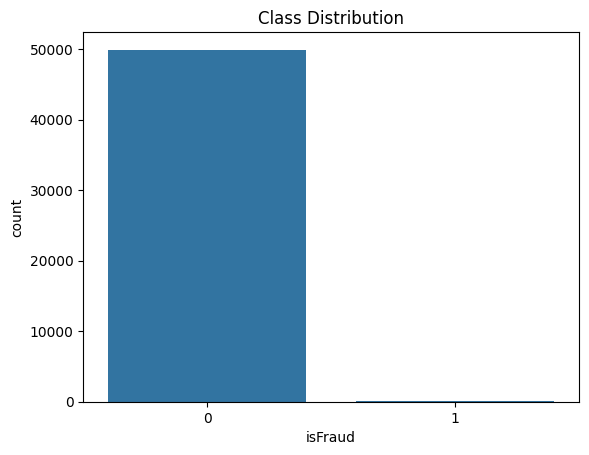

In [21]:
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution')
plt.show()

Variabel `'isFraud'` yang menjadi variabel target tidak seimbang (*imbalanced*). Yang menjadi mayoritas adalah non-fraudulent (0).

Dengan rincian:
*   non-fraudulent (0): 49900
*   fraud (1): 100





# Modelling #1

In [22]:
# Separate features and target variable
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [23]:
# Feature scalling
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [24]:
# Divide data in training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

In [25]:
# Build model and fit data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict new y value based on x test values
y_predict = lr.predict(X_test)

# Create confusion matrix to evaluate results
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    index=['actual no', 'actual yes'],
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,9980,0
actual yes,19,1


In [26]:
# Prediksi label menggunakan data uji
y_predict = lr.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_predict))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_predict))

print(" ")

# Model Accuracy Score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_predict)))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       1.00      0.05      0.10        20

    accuracy                           1.00     10000
   macro avg       1.00      0.53      0.55     10000
weighted avg       1.00      1.00      1.00     10000


Confusion Matrix:
[[9980    0]
 [  19    1]]
 
Model accuracy score: 0.9981


In [27]:
# Lihat koefisien
print("Intercept:", lr.intercept_)
print("Koefisien:", lr.coef_)

Intercept: [-11.24256944]
Koefisien: [[ 0.03351576  3.20046534 -3.36756871 -1.17232577 -1.18468195 -1.07532813
   2.12542407 -0.31284264 -2.01333607  1.70630721]]


In [28]:
# Dapatkan koefisien dan intercept
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Cetak persamaan logistik
logit_eq = f"logit(p) = {intercept:.4f}"
for i, coef in enumerate(coefficients):
    logit_eq += f" + ({coef:.4f} * X{i+1})"

logistic_eq = f"p = 1 / (1 + exp(-({intercept:.4f}"
for i, coef in enumerate(coefficients):
    logistic_eq += f" + ({coef:.4f} * X{i+1})"
logistic_eq += ")))"

print("Persamaan logit regresi logistik:")
print(logit_eq)
print("\nPersamaan regresi logistik:")
print(logistic_eq)

Persamaan logit regresi logistik:
logit(p) = -11.2426 + (0.0335 * X1) + (3.2005 * X2) + (-3.3676 * X3) + (-1.1723 * X4) + (-1.1847 * X5) + (-1.0753 * X6) + (2.1254 * X7) + (-0.3128 * X8) + (-2.0133 * X9) + (1.7063 * X10)

Persamaan regresi logistik:
p = 1 / (1 + exp(-(-11.2426 + (0.0335 * X1) + (3.2005 * X2) + (-3.3676 * X3) + (-1.1723 * X4) + (-1.1847 * X5) + (-1.0753 * X6) + (2.1254 * X7) + (-0.3128 * X8) + (-2.0133 * X9) + (1.7063 * X10))))


# Mengaplikasikan SMOTE

In [29]:
# Shuffle the data
df = df.sample(frac=1, random_state=42)

# Print the initial class distribution
print("Initial class distribution:")
print(df['isFraud'].value_counts())

# Separate features and target variable
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Convert the resampled arrays to DataFrame
X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_series = pd.Series(y_res, name='isFraud')

# Combine the resampled features and target variable into a DataFrame
resampled_df = pd.concat([X_res_df, y_res_series], axis=1)

# Print the resampled class distribution
print("Resampled class distribution:")
print(resampled_df['isFraud'].value_counts())

# Create a balanced dataset with 25000 fraud and 25000 non-fraud samples
fraud_df = resampled_df[resampled_df['isFraud'] == 1].sample(n=25000, random_state=42)
non_fraud_df = resampled_df[resampled_df['isFraud'] == 0].sample(n=25000, random_state=42)

# Combine the balanced samples
balanced_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the combined DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Print the final class distribution
print("Final class distribution:")
print(balanced_df['isFraud'].value_counts())

# Display the first few rows
print(balanced_df.head())

Initial class distribution:
isFraud
0    49900
1      100
Name: count, dtype: int64
Resampled class distribution:
isFraud
0    49900
1    49900
Name: count, dtype: int64
Final class distribution:
isFraud
0    25000
1    25000
Name: count, dtype: int64
             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
43982  9.633050e+03       0.000000             0.0        0.000000   
66975  2.377330e+05  237732.952791             0.0     1790.824096   
87446  3.405947e+04   34059.473076             0.0    13073.216654   
60990  8.963124e+04   89631.240000             0.0     3953.299404   
30426  1.884744e+06   34945.000000             0.0        0.000000   

       newbalanceDest  type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
43982    0.000000e+00           0.0       0.000000         0.0           1.0   
66975    2.538565e+05           0.0       1.000000         0.0           0.0   
87446    3.169659e+03           0.0       0.419821         0.0           0.0   
60990  

In [30]:
df_smote = balanced_df
df_smote.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
43982,9.633050e+03,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,1.0,0.000000,0
66975,2.377330e+05,237732.952791,0.0,1790.824096,2.538565e+05,0.0,1.000000,0.0,0.0,0.000000,1
87446,3.405947e+04,34059.473076,0.0,13073.216654,3.169659e+03,0.0,0.419821,0.0,0.0,0.580179,1
60990,8.963124e+04,89631.240000,0.0,3953.299404,0.000000e+00,0.0,0.186697,0.0,0.0,0.813303,1
30426,1.884744e+06,34945.000000,0.0,0.000000,3.051600e+06,0.0,0.000000,0.0,0.0,1.000000,0


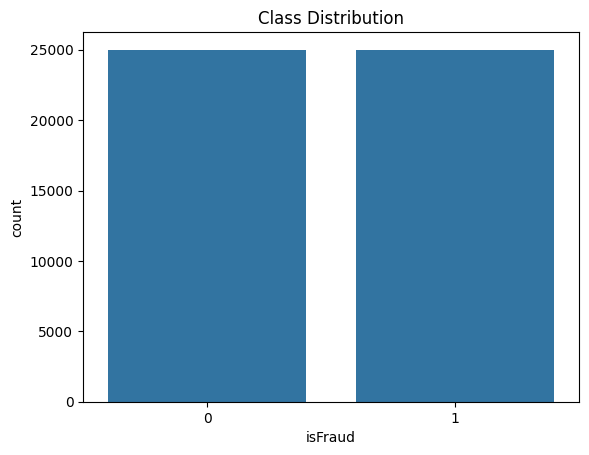

In [31]:
sns.countplot(x='isFraud', data=df_smote)
plt.title('Class Distribution')
plt.show()

# Modelling (Setelah SMOTE)

In [32]:
# Separate features and target variable
X1 = df_smote.drop(columns=['isFraud'])
y1 = df_smote['isFraud']

In [33]:
# Feature scalling
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

In [34]:
# Divide data in training set and test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state = 42)

In [35]:
# Build model and fit data
lr1 = LogisticRegression()
lr1.fit(X1_train, y1_train)

# Predict new y value based on x test values
y1_predict = lr1.predict(X1_test)

# Create confusion matrix to evaluate results
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y1_test, y1_predict),
    index=['actual no', 'actual yes'],
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,4322,650
actual yes,125,4903


In [36]:
# Prediksi label menggunakan data uji
y1_predict = lr1.predict(X1_test)

# Classification Report
print("Classification Report (Setelah SMOTE):")
print(classification_report(y1_test, y1_predict))

# Confusion Matrix
print("\nConfusion Matrix (Setelah SMOTE):")
print(confusion_matrix(y1_test, y1_predict))

print(" ")

# Model Accuracy Score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y1_test, y1_predict)))

Classification Report (Setelah SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      4972
           1       0.88      0.98      0.93      5028

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000


Confusion Matrix (Setelah SMOTE):
[[4322  650]
 [ 125 4903]]
 
Model accuracy score: 0.9225


In [37]:
# Lihat koefisien
print("Intercept:", lr1.intercept_)
print("Koefisien:", lr1.coef_)

Intercept: [-3.37977284]
Koefisien: [[-6.89176135e+00  2.09369411e+01 -2.72141453e+01 -1.20169922e+00
  -6.66880271e-03 -1.29268712e+00  1.30385516e+00 -4.19945822e-01
  -2.70853716e+00  2.12281918e+00]]


In [38]:
# Dapatkan koefisien dan intercept
intercept = lr1.intercept_[0]
coefficients = lr1.coef_[0]

# Cetak persamaan logistik
logit_eq = f"logit(p) = {intercept:.4f}"
for i, coef in enumerate(coefficients):
    logit_eq += f" + ({coef:.4f} * X{i+1})"

logistic_eq = f"p = 1 / (1 + exp(-({intercept:.4f}"
for i, coef in enumerate(coefficients):
    logistic_eq += f" + ({coef:.4f} * X{i+1})"
logistic_eq += ")))"

print("Persamaan logit regresi logistik:")
print(logit_eq)
print("\nPersamaan regresi logistik:")
print(logistic_eq)

Persamaan logit regresi logistik:
logit(p) = -3.3798 + (-6.8918 * X1) + (20.9369 * X2) + (-27.2141 * X3) + (-1.2017 * X4) + (-0.0067 * X5) + (-1.2927 * X6) + (1.3039 * X7) + (-0.4199 * X8) + (-2.7085 * X9) + (2.1228 * X10)

Persamaan regresi logistik:
p = 1 / (1 + exp(-(-3.3798 + (-6.8918 * X1) + (20.9369 * X2) + (-27.2141 * X3) + (-1.2017 * X4) + (-0.0067 * X5) + (-1.2927 * X6) + (1.3039 * X7) + (-0.4199 * X8) + (-2.7085 * X9) + (2.1228 * X10))))


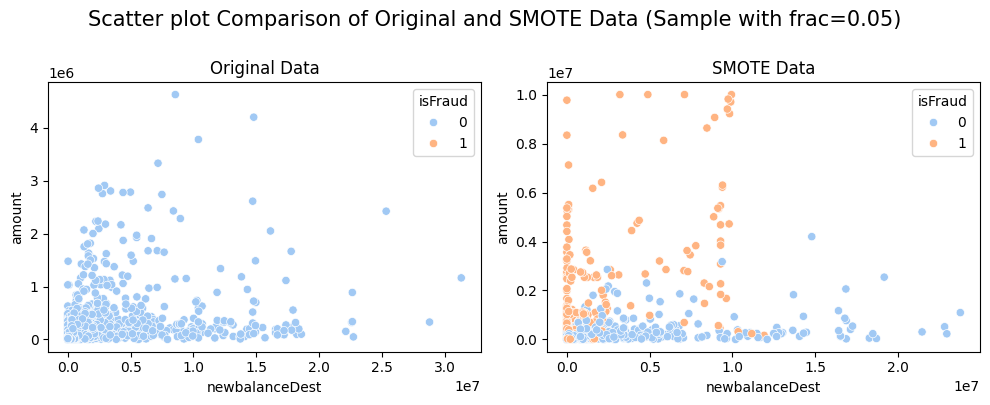

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

frac = 0.05 # Using a smaller fraction will reduce the execution time.

# First subplot
sns.scatterplot(x="newbalanceDest", y="amount", hue="isFraud", data=df.sample(frac=frac, random_state=42), palette="pastel", ax=axes[0])
axes[0].set_title("Original Data")

# Second subplot
sns.scatterplot(x="newbalanceDest", y="amount", hue="isFraud", data=df_smote.sample(frac=frac, random_state=42), palette="pastel", ax=axes[1])
axes[1].set_title("SMOTE Data")

# Main title
fig.suptitle('Scatter plot Comparison of Original and SMOTE Data (Sample with frac=0.05)', fontsize=15, y=1)
plt.tight_layout()
plt.show()